# Autoencoder Application: Denoising Graphene EM Images


Electron microscopy (EM) images of graphene can be used to constrain the lifetime and evolution of structural defects. However, exposing them to the EM beam will induce their decay and thus interfere with any conclusions made. To prevent such interference, the samples can be imaged at lower doses, but doing so will also decrease the signal-to-noise ratio (SNR). We wish to reduce the noise while preserving the underlying atomic structure in the image.

In this notebook, we will train an autoencoder that transforms a noisy EM image of graphene to a clean one. Different from [autoencoder_basics.ipynb](autoencoder_basics.ipynb), the input and output images will be different in this case.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Concatenate, Conv2DTranspose

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.1


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop-data'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path + 'sciml-workshop/'
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]
    

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {bucket_name} 

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

apt -qq update
apt -qq install s3fs fuse
mkdir -p $2
s3fs $3 $2 -o allow_other,use_path_request_style,no_check_certificate,public_bucket=1,ssl_verify_hostname=0,host=https://s3.echo.stfc.ac.uk,url=https://s3.echo.stfc.ac.uk

Running notebook locally.


---

# The dataset


Similar to [CNN_practical.ipynb](../CNN/CNN_practical.ipynb), we open the data file using the `tf.data.Dataset` class, which supports on-demand data loading from disk to memory. The dataset contains two sets of images, respectively named "noise" and "clean". There are totally 1000 pairs of noisy and clean images in the file.

### Open data file

In [4]:
# define image size
IMG_WIDTH = 64
IMG_HEIGHT = 64
N_CHANNELS = 1

# generator'
def hdf_generator(path, buffer_size=128):
    """ Load data DMS data from disk
    
    Args:
        path: path of the HDF file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['noisey'].shape
        for i in range(0, n_samples, buffer_size):
            noise = handle['noisey'][i:i+buffer_size]
            clean = handle['clean'][i:i+buffer_size]
            yield noise, clean

# dataset
dataset_file = tf.data.Dataset.from_generator(lambda: hdf_generator(path=data_path + 'em-data/train.h5'), 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                             (None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print(dataset_file)

<FlatMapDataset shapes: ((None, 64, 64, 1), (None, 64, 64, 1)), types: (tf.float32, tf.float32)>


### Process dataset

Next, we use the methods of `tf.data.Dataset` to process the input data using the following recipe:

1. Unbatch the dataset;
2. Shuffle the dataset with a buffer size of 200;
3. Normalise the pixel values to [-1, 1] using the following formula:
> $x_\text{norm}=2 \dfrac{x -  \min(x)}{\max(x) - \min(x)} - 1;$
4. Re-batch the dataset to size 32.

In [5]:
# unbatch
dataset = dataset_file.unbatch()

# shuffle
dataset = dataset.shuffle(200)

# normalize
def normalize(X, Y):
    X = 2 * (X - tf.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X)) - 1
    Y = 2 * (Y - tf.reduce_min(Y)) / (tf.math.reduce_max(Y) - tf.math.reduce_min(Y)) - 1
    return X, Y
dataset = dataset.map(normalize)

# re-batch
dataset = dataset.batch(32)

### Plot examples

Now we can plot a could of examples. The noisy images displayed in the top row will be the input for our autoencoder, and the corresponding clean ones in the bottom row the output for our autoencoder. 

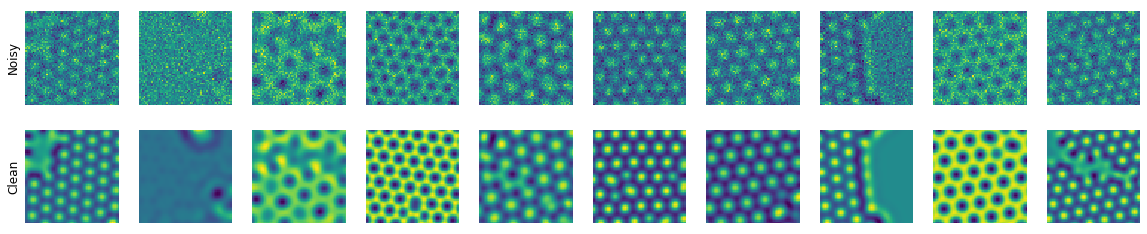

In [6]:
# take the first buffer
noisy, clean = list(dataset.take(1))[0]

# plot 10 pairs
nplot = 10
fig, axes = plt.subplots(2, nplot, figsize=(nplot * 2, 4))
for ax, img_noise, img_clean in zip(axes.T, noisy[:nplot], clean[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])   
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
plt.show()

---

# Denoising by Autoencoder

## 1. Network architecture

We provide the following suggested network architecture, using multiple levels of convolutional layers for encoding and decoding. 

In this network, we employ a technique called **skip connections**, as implemented by the variable `skip_layers`. Here "skip" means that the information will be teleported from the encoder to the decoder, skipping the bottleneck. The skip connections are introduced to compensate for the information loss because of encoding and decoding, which can help the autoencoder to reconstruct denoised images with less artefacts (such as aliasing and patching).

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# skip connections
skip_layers = []
    
# input
input_layer = Input((IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = input_layer


# encoder ------------------------------------------------------------------- #
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)
# encoder ------------------------------------------------------------------- #


# bottleneck ---------------------------------------------------------------- #
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
# bottleneck ---------------------------------------------------------------- #


# decoder ------------------------------------------------------------------- #
x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  

x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  

x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
# decoder ------------------------------------------------------------------- #


# output
x = Conv2DTranspose(filters=1, kernel_size=3, activation='linear', padding='same')(x)

# model
model = Model(input_layer, x)
model.summary()
```
    
</p>
</details>

In [7]:
# skip connections
skip_layers = []
    
# input
input_layer = Input((IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = input_layer


# encoder ------------------------------------------------------------------- #
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
skip_layers.append(x)
x = MaxPool2D()(x)
# encoder ------------------------------------------------------------------- #


# bottleneck ---------------------------------------------------------------- #
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
# bottleneck ---------------------------------------------------------------- #


# decoder ------------------------------------------------------------------- #
x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  

x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  

x = UpSampling2D()(x)
x = Concatenate()([x, skip_layers.pop(-1)])
x = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
x = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)  
# decoder ------------------------------------------------------------------- #


# output
x = Conv2DTranspose(filters=1, kernel_size=3, activation='linear', padding='same')(x)

# model
model = Model(input_layer, x)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         batch_normalization[0][0]        
_______________________________________________________________________________________

## 2. Compile the model

Now we compile the model using a custom loss function based on the structural similarity index measure ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity)). Compared to pixel-wise measurements (such as mean squared error) that estimate absolute errors, SSIM quantifies the similarity in structural information and thus better serves our purpose. Our implementation of SSIM is based on `tf.image.ssim`. We also add the mean absolute error (MAE) to the loss function to regularise the solution.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# SSIM loss
def ssim_loss(y_actual, y_pred):
    ssim = tf.image.ssim(y_actual, y_pred, max_val=2.0)
    mae = tf.keras.losses.MAE(y_actual, y_pred)
    return 1 - tf.reduce_mean(ssim) + 0.4 * mae

# compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=.001), loss=ssim_loss)
```
    
</p>
</details>

In [8]:
# SSIM loss
def ssim_loss(y_actual, y_pred):
    ssim = tf.image.ssim(y_actual, y_pred, max_val=2.0)
    mae = tf.keras.losses.MAE(y_actual, y_pred)
    return 1 - tf.reduce_mean(ssim) + 0.4 * mae

# compile the model
model.compile(optimizer=keras.optimizers.Adam(lr=.001), loss=ssim_loss)

## 3. Train the model

We need `epochs=50` to obtain an acceptable denoising quality, which will take about 2 minutes for training. Use more epochs (>500) to improve the accuracy.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(dataset, epochs=50, batch_size=32)
    
# plot training history
plt.plot(training_history.history['loss'])
```
    
</p>
</details>

Epoch 1/50
32/32 [==============================] - 18s 564ms/step - loss: 0.8951
Epoch 2/50
32/32 [==============================] - 19s 580ms/step - loss: 0.4873
Epoch 3/50
32/32 [==============================] - 21s 647ms/step - loss: 0.4261
Epoch 4/50
32/32 [==============================] - 21s 652ms/step - loss: 0.4089
Epoch 5/50
32/32 [==============================] - 20s 630ms/step - loss: 0.3973
Epoch 6/50
32/32 [==============================] - 21s 659ms/step - loss: 0.3942
Epoch 7/50
32/32 [==============================] - 19s 600ms/step - loss: 0.3835
Epoch 8/50
32/32 [==============================] - 21s 664ms/step - loss: 0.3871
Epoch 9/50
32/32 [==============================] - 32s 987ms/step - loss: 0.3916
Epoch 10/50
32/32 [==============================] - 31s 973ms/step - loss: 0.3694
Epoch 11/50
32/32 [==============================] - 27s 836ms/step - loss: 0.3701
Epoch 12/50
32/32 [==============================] - 19s 586ms/step - loss: 0.3628
Epoch 13/50
3

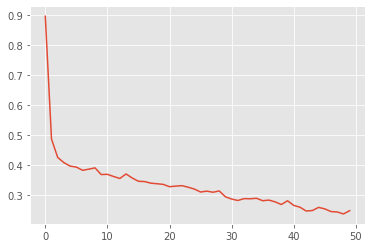

In [9]:
# train the model
training_history = model.fit(dataset, epochs=50)

# plot training history
plt.plot(training_history.history['loss'])

## 4. Denoise the images

Finally, we can use our trained autoencoder to denoise the images:

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# denoise by predict
denoised = model.predict(noisy)
    
# plot results
nplot = 5
fig, axes = plt.subplots(3, nplot, figsize=(nplot * 2, 6))
for ax, img_noise, img_clean, img_denoised in zip(axes.T, noisy[:nplot], clean[:nplot], denoised[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].matshow(np.squeeze(img_denoised))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
axes[2, 0].set_ylabel('Denoised', c='k')
plt.show()
```
    
</p>
</details>

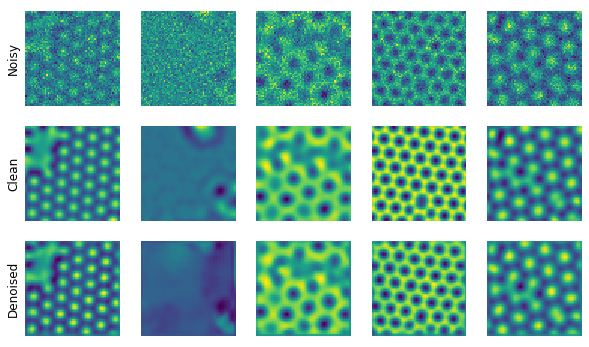

In [10]:
# denoise by predict
denoised = model.predict(noisy)
    
# plot results
nplot = 5
fig, axes = plt.subplots(3, nplot, figsize=(nplot * 2, 6))
for ax, img_noise, img_clean, img_denoised in zip(axes.T, noisy[:nplot], clean[:nplot], denoised[:nplot]):
    ax[0].matshow(np.squeeze(img_noise))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].matshow(np.squeeze(img_clean))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].matshow(np.squeeze(img_denoised))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
axes[0, 0].set_ylabel('Noisy', c='k')
axes[1, 0].set_ylabel('Clean', c='k')
axes[2, 0].set_ylabel('Denoised', c='k')
plt.show()

---

## Exercises

Suppose that we have a set of noisy images and a set of clean images but they are completely independent; e.g., they can be obtained from different samples and can be different in size. Such a situation commonly occurs when the "noisy" data are collected from the nature while we can synthesise the "clean" data in the laboratory. 

Design and train an autoencoder using the clean images as *both* its input and output and use the autoencoder to denoise the noisy images. Note that because the input and output are now identical, the network architecture can be simpler and the skip connections are no longer required. 

**Hint**: To get the training dataset with the clean images as both input and output, we can simply do

```python
dataset_clean_as_both_IO = dataset.map(lambda X, Y: (Y, Y))
```